<a href="https://colab.research.google.com/github/he16946/Data_Labs/blob/master/Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spotify Data

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ['KAGGLE_USERNAME'] = "ce889group3" # username from the json file

os.environ['KAGGLE_KEY'] = "f0ec34f29bf37cceb765b25f5a1bce2c" # key from the json file

!kaggle datasets download -d geomack/spotifyclassification


  0% 0.00/98.4k [00:00<?, ?B/s]
100% 98.4k/98.4k [00:00<00:00, 36.2MB/s]


In [0]:
! unzip -q "spotifyclassification.zip"

In [0]:
df = pd.read_csv("data.csv")

## Check data for NaNs

In [6]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [7]:
df.isna().sum() 

Unnamed: 0          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
song_title          0
artist              0
dtype: int64

## Find imbalance of dataset

In [9]:
print('Like', round(df['target'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Dislike', round(df['target'].value_counts()[0]/len(df) * 100,2), '% of the dataset')

Like 50.57 % of the dataset
Dislike 49.43 % of the dataset


(array([650.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 350.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

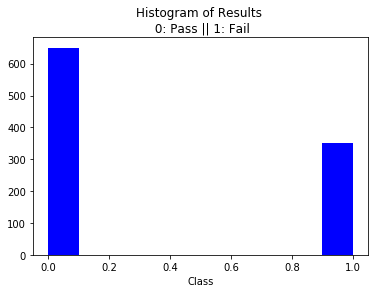

In [0]:
plt.title('Histogram of Results \n 0: Pass || 1: Fail')
plt.xlabel('Class')
plt.hist(df['Results'], color='blue')